/tmp/ipykernel_21065/602853961.py:39: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


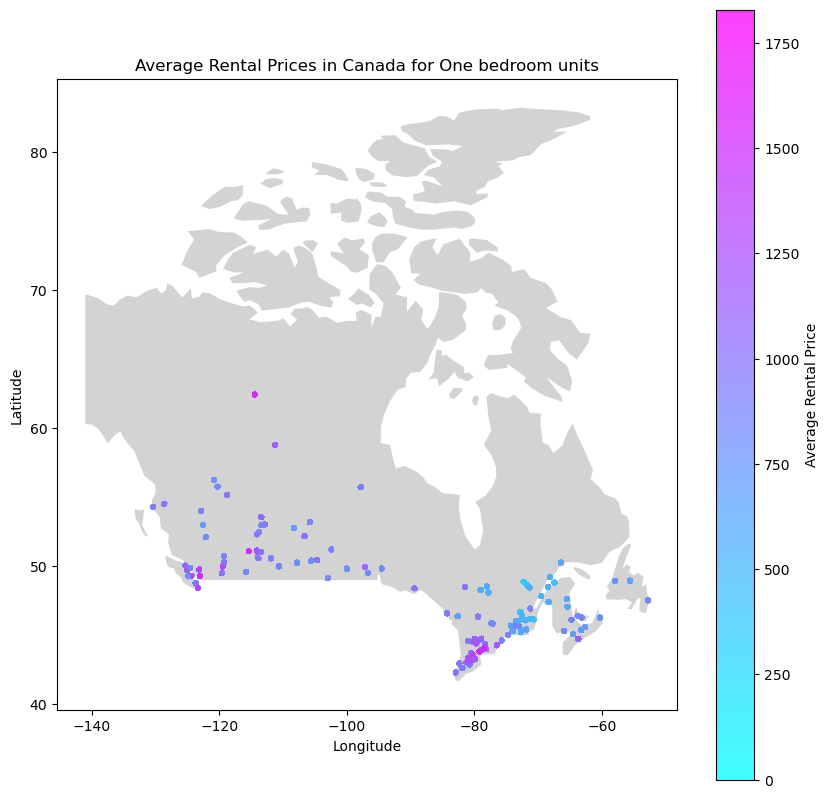

In [6]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Constants
#rental_type= "Bachelor units"
rental_type="One bedroom units"
#rental_type="Two bedroom units"
#rental_type="Three bedroom units"
encoding='ISO-8859-1'

# Load the rental prices data with the specified encoding
rental_prices = pd.read_csv('data/rental_prices.csv', encoding=encoding, low_memory=False)

# Filter and clean the rental prices data
rents = rental_prices.query(f'STATUS != "F" and STATUS != ".." and `Type of unit` == "{rental_type}"').copy()
rents.loc[:, 'CITY'] = rents['GEO'].apply(lambda row: row.split(",")[0])
rents.loc[:, 'DGUID'] = rents['DGUID'].str[4:]  # Remove the first four characters

# Load the Geographic Attribute File with selected columns and specified encoding
columns_to_keep = ['CMADGUID_RMRIDUGD', 'CSDNAME_SDRNOM', 'DARPLAT_ADLAT', 'DARPLONG_ADLONG']
geo_attributes = pd.read_csv('data/geographic_attributes.csv', usecols=columns_to_keep, encoding=encoding, low_memory=False)
geo_attributes['CMADGUID_RMRIDUGD'] = geo_attributes['CMADGUID_RMRIDUGD'].str[4:]  # Remove the first four characters

# Remove duplicates based on the 'CMADGUID_RMRIDUGD' and 'CSDNAME_SDRNOM' columns
geo_attributes = geo_attributes.drop_duplicates(subset=['CMADGUID_RMRIDUGD', 'CSDNAME_SDRNOM'])

# Save the filtered Geographic Attribute File to a new CSV file
geo_attributes.to_csv('data/filtered_geographic_attributes.csv', index=False)

# Merge the rental prices data with the filtered Geographic Attribute File
# Ensure that both the DGUID and city name match
merged_data = pd.merge(rents, geo_attributes, left_on=['DGUID', 'CITY'], right_on=['CMADGUID_RMRIDUGD', 'CSDNAME_SDRNOM'], how='left')

# Filter out rows with missing coordinates
merged_data.dropna(subset=['DARPLAT_ADLAT', 'DARPLONG_ADLONG'], inplace=True)

# Load world map and filter for Canada
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
canada = world.query("name == 'Canada'")

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
canada.plot(color="lightgrey", ax=ax)
scatter = ax.scatter(x=merged_data['DARPLONG_ADLONG'], y=merged_data['DARPLAT_ADLAT'], c=merged_data['VALUE'], cmap='cool', s=8, alpha=0.75)
plt.colorbar(scatter, ax=ax, label='Average Rental Price')
plt.title(f'Average Rental Prices in Canada for {rental_type}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()